<a href="https://colab.research.google.com/github/s208739v/robot_sim/blob/main/robot_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.patches as patches

In [ ]:

STEP = 100
dt = 0.1
dx = 0.01
dy = dx

MAX_SPEED = 1


NUM_ROBOT = 10
NUM_CONTAINER = 1

MASS_ROBOT = 5.
MASS_CONTAINER = 100

MOMENT_OF_INERTIA_CONTAINER = 10000

SIZE_ROBOT = 0.

MU_FRICTION_ROBOT = 10
K = 200
K_T = 10
g = 9.81

DTYPE = np.float64

C = 10 #速度依存の抵抗用

F_STEERING = 50

class Robot:
    ID = 0
    poss = []
    sizes = []
    dirs = []
    vs = []
    loc_2s = [] #標準偏差の計算用
    cg = np.array([0,0,0],dtype=DTYPE) #ロボットの重心
    loc_cg = np.array([0,0,0],dtype = DTYPE) # コンテナ基準のロボットの重心
    std = 0

    target_dir = np.array([0,0,0],dtype=DTYPE) #コンテナの目標移動方向

    def __init__(self, mass=MASS_ROBOT,size=SIZE_ROBOT, type = "robot", position= np.array([0,0,0],dtype=DTYPE),target_id=0):
        self.id = self.ID
        self.ID+=1

        self.pos = np.array([0,0,0],dtype=DTYPE) #現在位置(x,y,z)
        self.pospre = self.pos #t-dtでの位置
        self.v = 0 #速さ
        self.theta = 0
        self.angular_v = 0

        self.F = np.array([0,0,0],dtype=DTYPE) #力ベクトル
        self.fn_sum = np.array([0,0,0],dtype=DTYPE) #接線方向の力
        self.dir = np.array([0,0,0],dtype=DTYPE) #進行方向ベクトル
        self.dt_pre = [np.array([0,0,0],dtype=DTYPE) for i in range(NUM_ROBOT+NUM_CONTAINER)] #接線方向侵入量
        self.state = "out_of_area" #位置によって状態変数を変更

        self.rot_amount = 0 #回転量。コンテナだけ使う

        self.target_id = target_id
        self.target = np.array([0,0,0],dtype=DTYPE) #マーカーの位置


        self.k = K #ペナルティ法のバネ定数
        self.k_t = K_T

        self.type = type
        self.size = size
        self.mass = mass
        self.moment_of_inertia = MOMENT_OF_INERTIA_CONTAINER

        self.set_pos(position)
        self.poss.append(self.pos)
        self.sizes.append(self.size)
        self.dirs.append(self.dir)
        self.vs.append(self.v*self.dir)
        self.loc_2s .append(0)

    def set_pos(self,position):
        self.pos = position
        self.pospre = self.pos

    def evolution(self): #力を計算して運動方程式を解く
        self.solve_eom()

    def solve_eom(self): #運動方程式を解く. 

        F, momentum = self.calc_force(self.pos, self.v*self.dir) #力の計算

        self.pos, V = self.verlet(F, self.pos, self.v*self.dir,self.mass) #並進運動方程式を解く

        if self.type == "container": #回転運動
            self.theta, self.angular_v = self.verlet(momentum[2], self.theta, self.angular_v, self.moment_of_inertia)

        self.v = np.linalg.norm(V,ord=2)
        if self.v !=0:
            self.dir = V/self.v #進行方向ベクトルの算出
        else:
            self.dir = V #[0,0,0]
    
        self.dirs[self.id]=self.dir
        self.vs[self.id]=self.v

    def calc_force(self, x, v): #力の計算
        F = np.array([0,0,0],dtype=DTYPE)
        momentum = np.array([0,0,0],dtype=DTYPE)

        F += self.steering(x,v)
        F += self.resistance(x,v)
        f_c, momentum_c = self.detect_contact(x,v)
        F += f_c
        momentum += momentum_c
        self.F = F

        return F, momentum

    def detect_contact(self, x, v): #接触判定と接触力の計算
        f_contact = np.array([0,0,0],dtype=DTYPE)
        ft = np.array([0,0,0],dtype=DTYPE)
        fn = np.array([0,0,0],dtype=DTYPE)
        momentum = np.array([0,0,0],dtype=DTYPE)

        for i in range(NUM_ROBOT+NUM_CONTAINER):
            l = self.poss[i]-x #相対位置ベクトル
            l_norm =  np.linalg.norm(l) #距離
            d_n = (self.size+self.sizes[i])- l_norm #侵入量
      
            if d_n>0 and i!=self.id: #接触判定
                v = (self.v*self.dir)-self.vs[i]*self.dirs[i] #相対速度
                vn = np.dot(v,l)*l/(l_norm**2) #相対速度(法線方向)
                vt = v-vn #相対速度(接線方向)

                if np.linalg.norm(vt)!=0:#接線方向単位ベクトルの計算
                    t = vt/np.linalg.norm(vt)
                elif np.linalg.norm(self.dt_pre[i]!=0):
                    t =self.dt_pre[i]/np.linalg.norm(self.dt_pre[i])
                else:
                    t = np.array([0,0,0],dtype=DTYPE)

                d_t = np.linalg.norm(self.dt_pre[i])*t+vt*dt #接線方向の侵入ベクトル
                self.dt_pre[i] = d_t

                if l_norm!=0: #大半の場合こっち完全に重心が重なったときはelseの方に
                    fn += -self.k*d_n*l/l_norm #法線方向
                    ft += -self.k_t*d_t #接線方向
                    f_contact += (fn+ft)

                    if self.type == "container": #コンテナの時は回転も考えるのでモーメント計算
                        momentum = np.cross(l,ft)

                else:
                  f_contact+= -self.k*d_n*self.dirs[i]
            
            else: #接触していない場合、法線方向の変位をリセット
                self.dt_pre[i] = np.array([0,0,0],dtype=DTYPE)

            return f_contact, momentum

    def steering(self,x, v): #操舵力（入力）の計算
        #制御方法で分岐
        if self.type == "container": #制御なし。コンテナ
            return np.array([0,0,0],dtype=DTYPE)
        else:
            loc = x-self.poss[NUM_ROBOT] #コンテナ基準の座標
            loc_norm = loc/np.linalg.norm(loc)
            loc_t = self.rot_z(90,loc_norm) * np.dot(self.rot_z(90,self.target_dir), loc_norm)#接線方向単位ベクトル
      
            loc_1 = np.dot(self.target_dir, loc)*self.target_dir #進行方向成分
            loc_2 = np.dot(self.rot_z(90,self.target_dir), loc)*self.rot_z(90,self.target_dir)
            self.loc_2s[self.id] = np.dot(self.rot_z(90,self.target_dir), loc)

            loc_cg_2 = np.dot(self.loc_cg, self.rot_z(90,self.target_dir))*self.rot_z(90,self.target_dir)
 
            if np.linalg.norm(loc)>200: #離れてるときは単純にコンテナの方へ
                self.state = "out_of_area"
                r = -(loc_1+loc_2)
                r/=np.linalg.norm(r)
                return F_STEERING*r

            else:
                if np.dot(self.target_dir, loc_norm)<=np.cos(90): #搬送位置にあるとき
                    self.state = "pushing"
                    #r = -20*(loc_1+loc_2)/np.linalg.norm(loc_1+loc_2)  +45*(self.std/2-1)*loc_t - 5*loc_cg_2
                    r = 20*self.target_dir  +30*(self.std/1-1)*loc_t - 5*loc_cg_2
                    r/=np.linalg.norm(r)
                    return F_STEERING*r  #コンテナ中心に向かう力+標準偏差制御＋重心制御
                else:
                    r =  10*(loc_1+loc_2)/np.linalg.norm(loc_1+loc_2)  +40*loc_t
                    r/=np.linalg.norm(r)
                    return F_STEERING*r
    
    def resistance(self, x, v): #抵抗の計算
        return -C*v

    def stuck(self, x,y):
    
        return 2

    def verlet(self,f,x,v,mass):
        pos_next =x+ v*dt + 0.5*dt*dt*f/mass
        V = v + f/mass*dt
        return pos_next,V

    def runge_kutta(self,f,x,v):
        k1 = f
        x = x+1/2*v*dt
        v = v+1/2*k1/self.m*dt

        k2 = self.calc_force(x+1/2*v*dt, v+1/2*k1/self.m*dt)
        #k3 = self.calc_force()
    
    def set_target(self,t):
        self.target = t

    def rot_z(self,deg,vec): #z軸回りにベクトルを回転させる関数
        theta = np.pi/180*deg
        rot = np.array([[np.cos(theta),-np.sin(theta),0],
                      [np.sin(theta),np.cos(theta),0],
                      [0,0,1]],dtype = DTYPE)
        ans = np.dot(rot,vec)
        return ans




In [ ]:
class History():
    def __init__(self):
        self.container_hist = []
        self.std_hist = []
        self.cg_hist = []
  
    def record(self,loc_container):
        self.container_hist.append(loc_container)
  
    def plot_hist(self):
        self.fig, self.ax = plt.subplots()


In [ ]:
class Environment():
    def __init__(self):

        self.robots = [] #ロボットオブジェクトを入れるリスト
        self.path =[] #経路
        self.container_hist = []#コンテナ位置の履歴
    
        self.set_robots()
        self.set_path(np.array([0,-20,0],dtype=DTYPE),np.array([0,1000,0],dtype=DTYPE))

        self.update_poss_dir()

    #def initializing():


    def sim(self):
        self.fig, self.ax = plt.subplots(figsize=(3,6))
        ani = animation.FuncAnimation(self.fig, self.update, frames=range(STEP), interval=100)
        ani.save('anime.gif', writer="imagemagick")
    
        # アニメーションオブジェクトを変数に代入
        anim = HTML(ani.to_jshtml())
        # 変数に代入したアニメーションオブジェクトを表示する
        display(anim)
        #ani.save('anim.gif', writer="imagemagick")

        #self.draw_result()


    def test(self): #ロボット一個、コンテナ一個で挙動テスト
        self.fig, self.ax = plt.subplots(figsize=(3,6))
        ani = animation.FuncAnimation(self.fig, self.update, frames=range(STEP), interval=100)
        # アニメーションオブジェクトを変数に代入
        anim = HTML(ani.to_jshtml())
        # 変数に代入したアニメーションオブジェクトを表示する
        display(anim)

    def update(self,frame): #FuncAnimation内で実行される関数. ループさせる
        self.ax.cla()
        self.ax.set_xlim(-30,30)
        self.ax.set_ylim(-30,90)

        self.ax.plot([Robot.poss[i][0] for i in range(NUM_ROBOT+NUM_CONTAINER)], [Robot.poss[i][1] for i in range(NUM_ROBOT+NUM_CONTAINER)], '+')
        cg = self.calc_cg()
        self.ax.plot(cg[0],cg[1],"+")
        self.calc_std()

        self.update_target_dir()
        self.record_hist()

        for k in range(50):
            self.ax.plot(self.path[k][0],self.path[k][1],"-")

        for i in range(NUM_ROBOT+NUM_CONTAINER):

            self.ax.quiver(self.robots[i].pos[0],self.robots[i].pos[1],self.robots[i].F[0]*10,self.robots[i].F[1]*10)
            c = patches.Circle(xy=(self.robots[i].pos[0], self.robots[i].pos[1]), radius=self.robots[i].size, fill=False, ec='r') #矢印の準備
            self.ax.add_patch(c)

            if i>=NUM_ROBOT: #コンテナの回転の可視化のために点をプロット
                self.ax.plot(self.robots[i].pos[0]+self.robots[i].size*np.cos(self.robots[i].theta)/2, self.robots[i].pos[1]+self.robots[i].size*np.sin(self.robots[i].theta)/2, "*")

            for k in range(50):
                self.ax.plot(self.path[k][0],self.path[k][1],"-")

            self.robots[i].evolution()
    
            #self.ax.plot(self.robots[0].target[0],self.robots[0].target[1] ,'+')
            #self.ax.plot(self.robots[1].target[0],self.robots[1].target[1] ,'+')

            self.update_poss_dir()

    def set_robots(self): #robotオブジェクトを追加

        for i in range(NUM_ROBOT):
          if i%2 == 0:
              self.robots.append(Robot(position=np.array([20*(np.random.rand()-0.5),-20,0],dtype=DTYPE),target_id=1))
          else:
              self.robots.append(Robot(position=np.array([20*(np.random.rand()-0.5),-20,0],dtype=DTYPE),target_id=2))

        print(self.robots)
        for i in range(NUM_CONTAINER):
            self.robots.append(Robot(position=np.array([0,0,0],dtype=DTYPE),mass=MASS_CONTAINER,size=10,type="container")) 

    def set_path(self,start,goal,mode = "sin"): #パスを設定
        if mode == "straight_line":
            vector = (goal-start)/50
            for i in range(100):
                self.path.append(start+vector*i)

        for i in range(100):
            y = 1*i
            self.path.append(np.array([5*np.sin(2*3.14*y/20),y,0],dtype = DTYPE))

    def update_poss_dir(self): #位置と進行方向をアップデート
        for i in range(NUM_ROBOT+NUM_CONTAINER):
            Robot.poss[i] = self.robots[i].pos
            Robot.dirs[i] = self.robots[i].dir

    def calc_cg(self): #ロボットの位置の重心
        Robot.cg = np.mean(Robot.poss[:NUM_ROBOT],axis=0)
        Robot.loc_cg = Robot.cg - Robot.poss[NUM_ROBOT]
        return Robot.cg
  
    def calc_std(self):
        std = np.std(np.array(Robot.loc_2s))
        Robot.std = std
        #print(std)

    def update_target_dir(self): #コンテナの目標移動方向を更新
        i = self.nearest_point_index(self.path,Robot.poss[NUM_ROBOT])
        r = np.array([0,0,0],dtype=DTYPE)

        #if robot.target_id == 1:
        #  r = self.rotz(-90,self.path[i+1]-self.path[i])
        #elif robot.target_id == 2:
        #  r = self.rotz(90,self.path[i+1]-self.path[i])

        #if np.linalg.norm(r) != 0:
        #  r = 20*r/np.linalg.norm(r)+self.path[i]

        r = self.path[i+1]-self.path[i]
        Robot.target_dir = (r/np.linalg.norm(r))


    def nearest_point_index(self,points, target_point): #リスト内の座標から、ある座標に最も近い座標のインデックスを返す関数
        min_distance = float('inf')
        min_index = 0
        for i, point in enumerate(points):
            d = np.linalg.norm(point-target_point)
            if i == 0:
                min_distance = d
            
            if d < min_distance:
                min_distance = d
                min_index = i
        
        return min_index

    def rotz(self,deg,vec):
        theta = np.pi/180*deg
        rot = np.array([[np.cos(theta),-np.sin(theta),0],
                      [np.sin(theta),np.cos(theta),0],
                      [0,0,1]],dtype = DTYPE)
        ans = np.dot(rot,vec)
        return ans

    def record_hist(self):
        self.container_hist.append(Robot.poss[NUM_ROBOT])

    def draw_result(self):
        plt.plot([self.container_hist[i][0] for i in range(STEP)], [self.container_hist[j][1] for j in range(STEP)])
        plt.plot([self.path[i][0] for i in range(100)], [self.path[j][1] for j in range(100)])
        plt.show()


[<__main__.Robot object at 0x7f9bb8b76c40>, <__main__.Robot object at 0x7f9bb8b76ac0>, <__main__.Robot object at 0x7f9bb8b76580>, <__main__.Robot object at 0x7f9bb8b76f10>, <__main__.Robot object at 0x7f9bb8b76d60>, <__main__.Robot object at 0x7f9bb8b76cd0>, <__main__.Robot object at 0x7f9bb8b762e0>, <__main__.Robot object at 0x7f9bb8b76fd0>, <__main__.Robot object at 0x7f9bb8b76b50>, <__main__.Robot object at 0x7f9bb8b76f40>]


/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


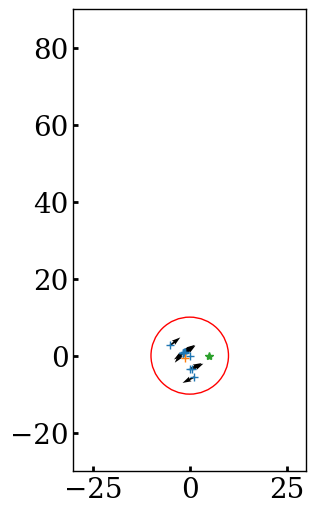

In [ ]:
E = Environment()
E.sim()

In [ ]:
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 2.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 2.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 20 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ
plt.rcParams["legend.framealpha"] = 1 #凡例を白く塗りつぶし
plt.rcParams["figure.figsize"] = [10,10] 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif'] #この辺はフォントをTimes New Romanに変えるためのやつ。あまり深く考えるな

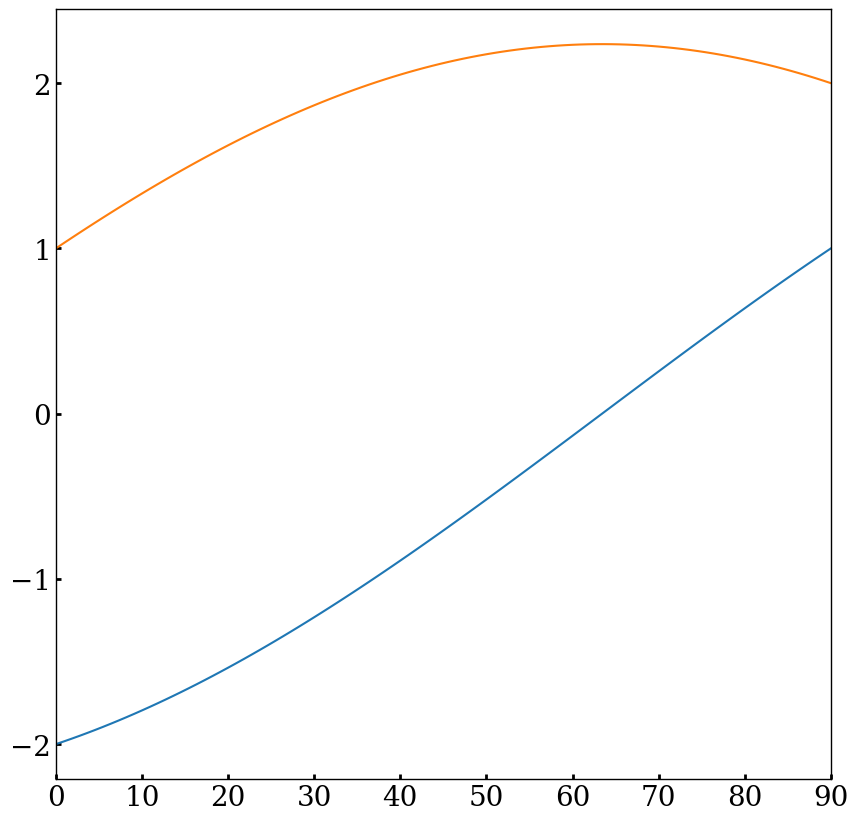

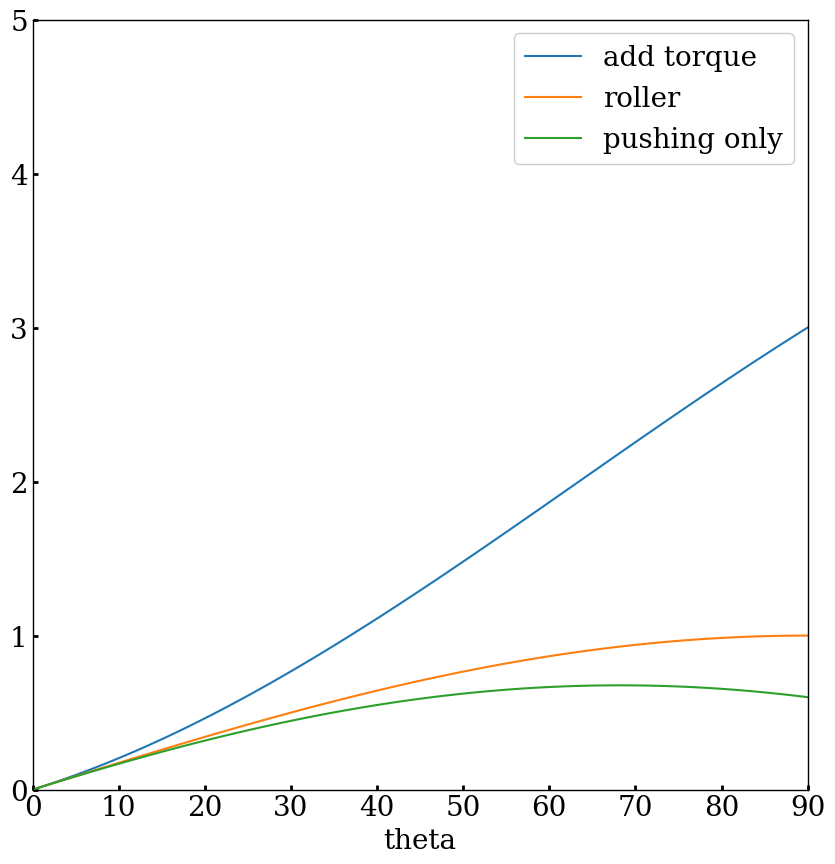

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
mu = 2
mu_dash=0.4
theta = np.linspace(0,np.pi/2,100)

fx_positive = np.sin(theta) -mu*np.cos(theta)
fy_positive = np.cos(theta) + mu*np.sin(theta)

d2xdt2_positive = np.sin(theta) -mu*np.cos(theta)+mu
d2xdt2_idle = np.sin(theta)
d2xdt2_negative = np.sin(theta)+mu_dash*np.cos(theta)-mu_dash

theta = theta*360/(2*np.pi)
plt.plot(theta,fx_positive)
plt.plot(theta,fy_positive)
plt.xlim(0,90)
plt.show()

plt.plot(theta, d2xdt2_positive, label="add torque")
plt.plot(theta, d2xdt2_idle, label = "roller")
plt.plot(theta, d2xdt2_negative, label = "pushing only")
plt.xlim(0,90)
plt.ylim(0,5)
plt.xlabel("theta")
plt.legend()
plt.show()